In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
env = gym.make("CartPole-v1")

In [6]:
ACTION_SIZE = env.action_space.n
STATE_SIZE = env.observation_space.shape[0]

NUM_EPISODES = 5000
LEARNING_RATE = 0.0005
DISCOUNT_FACTOR = 0.99

In [7]:
class ReinforceNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(ReinforceNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

In [8]:
def discount_rewards(episode_rewards, discount_factor):
    discounted_rewards = np.zeros_like(episode_rewards)
    cumulative_reward = 0
    for i in reversed(range(len(episode_rewards))):
        cumulative_reward = episode_rewards[i] + discount_factor * cumulative_reward
        discounted_rewards[i] = cumulative_reward
    return discounted_rewards


def normalize_rewards(episode_rewards):
    return (episode_rewards - np.mean(episode_rewards)) / (
        np.std(episode_rewards) + 1e-9
    )

In [9]:
def train(
    model: nn.Module,
    optimizer: optim.Optimizer,
    device: torch.device,
    env: gym.Env,
    num_episodes: int,
    discount_factor: float,
):
    reward_history = []
    for episode_idx in range(num_episodes):
        state, _ = env.reset()
        done = False
        step = 0
        episode_rewards, episode_log_probs = [], []
        while not done and step < 1000:
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            action_log_probs = model(state).squeeze(0)
            action_probs = torch.exp(action_log_probs)
            action = np.random.choice(
                range(ACTION_SIZE), p=action_probs.detach().cpu().numpy()
            )
            next_state, reward, terminated, truncated, _ = env.step(action)
            # Add reward based on distance from center
            reward += 1 - abs(next_state[0])
            done = terminated or truncated
            episode_rewards.append(reward)
            episode_log_probs.append(action_log_probs[action])
            state = next_state

        discounted_normalized_rewards = torch.tensor(
            normalize_rewards(discount_rewards(episode_rewards, discount_factor)),
            dtype=torch.float32,
            device=device,
        )
        loss = -torch.mean(
            torch.stack(episode_log_probs) * discounted_normalized_rewards
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        reward_history.append(sum(episode_rewards))

        if episode_idx % 50 == 0:
            print(
                f"Episode {episode_idx}, Total Reward: {sum(episode_rewards)}, Loss: {loss.item()}"
            )
        step += 1
    return reward_history

In [10]:
model = ReinforceNetwork(STATE_SIZE, ACTION_SIZE).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
env = gym.make("CartPole-v1")
rewards = train(model, optimizer, device, env, NUM_EPISODES, DISCOUNT_FACTOR)

/home/rabadaba/miniconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0, Total Reward: 23.515727363992482, Loss: 0.004256109707057476
Episode 50, Total Reward: 45.50459026457975, Loss: 0.0010563965188339353
Episode 100, Total Reward: 58.016944609582424, Loss: -0.002051234245300293
Episode 150, Total Reward: 32.70059407874942, Loss: -0.004374925047159195
Episode 200, Total Reward: 28.8786563584581, Loss: -0.0031989894341677427
Episode 250, Total Reward: 38.648459080432076, Loss: 0.004742753691971302
Episode 300, Total Reward: 32.70126130618155, Loss: -0.016801806166768074
Episode 350, Total Reward: 23.31571649480611, Loss: -0.045339878648519516
Episode 400, Total Reward: 44.3857465966139, Loss: -0.00827641598880291
Episode 450, Total Reward: 30.391809787601233, Loss: -0.07113829255104065
Episode 500, Total Reward: 66.41466927982401, Loss: -0.03833847865462303
Episode 550, Total Reward: 133.74130254262127, Loss: -0.06697838753461838
Episode 600, Total Reward: 37.4440876361914, Loss: -0.005743208806961775
Episode 650, Total Reward: 55.58712159018614

In [11]:
torch.save(model.state_dict(), "model.pth")

/home/rabadaba/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rabadaba/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


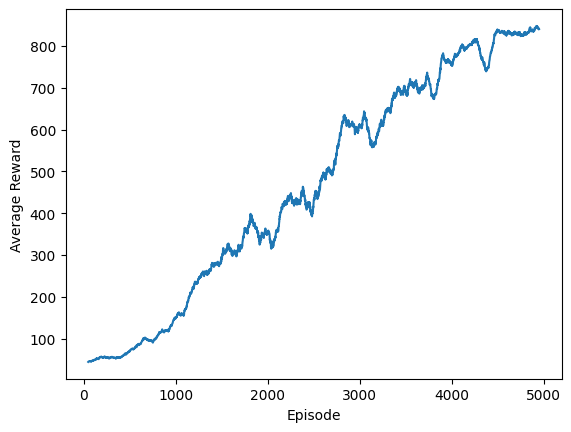

In [12]:
import matplotlib.pyplot as plt

avg_rewards = [np.mean(rewards[i - 100 : i]) for i in range(50, len(rewards))]
plt.plot(avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.show()

In [13]:
import time

env = gym.make("CartPole-v1", render_mode="human")
state, _ = env.reset()
done = False
while not done:
    env.render()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    action = torch.argmax(model(state)).item()
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    time.sleep(1 / 60)
env.close()

/home/rabadaba/miniconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
